In [104]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import datasets
import numpy as np
from matplotlib import pyplot

beta = 0.5
cutmix_prob = 1.0
num_classes = 100
batch_size = 6
r = 0.7 # fixed for cutmix display

def train_augment(image,label):
  image = tf.image.resize_with_crop_or_pad(image, 36, 36) 
  image = tf.image.random_crop(image, size=[32, 32, 3]) 
  image = tf.image.random_flip_left_right(image)
  image = tf.cast(image, dtype=tf.float32)
  label = tf.cast(label, dtype=tf.float32)
  return image,label

def rand_bbox(size, lam):

    W = size[1] 
    H = size[2]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)
    
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

# data loading
(train_images, train_labels), (test_images, test_labels) = datasets.cifar100.load_data()

# data pipeline
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.map(train_augment)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.shuffle(512)

# cutmix
for image, target in train_dataset:       
  if beta > 0 and r < cutmix_prob:
      lam = np.random.beta(beta, beta)
      rand_index = tf.random.shuffle(tf.range(len(target)))
      target_a = target
      target_b = tf.gather(target, rand_index)
      bbx1, bby1, bbx2, bby2 = rand_bbox(image.shape, lam)       
      image_a = image
      image_b = tf.gather(image, rand_index)
      mask = np.ones_like(image)
      mask[:, bbx1:bbx2, bby1:bby2, :] = 0          
      image_cutmix = tf.math.multiply(image_a,mask) + tf.math.multiply(image_b, (abs(1.-mask)))  # 영역을 0으로 만들어버린다.. 
  break

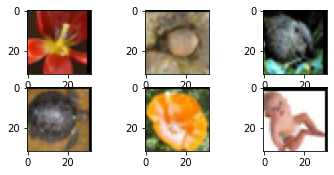

In [102]:
# Original images
from matplotlib import pyplot
for i in range(batch_size):
	pyplot.subplot(330 + 1 + i)
	pyplot.imshow(image[i]/255.)
pyplot.show()

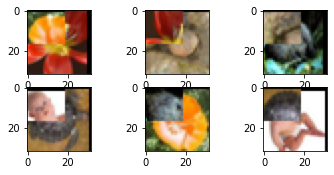

In [103]:
# Cutmix images
from matplotlib import pyplot
for i in range(batch_size):
	pyplot.subplot(330 + 1 + i)
	pyplot.imshow(image_cutmix[i]/255.)
pyplot.show()